### Import packages

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# standard imports and setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from datetime import datetime

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *

# data preparation
from sklearn.preprocessing import *

# classifers
from sklearn.linear_model import *
from xgboost import XGBClassifier

### Load Data

In [2]:
url = "https://nft-capstone.s3.us-west-1.amazonaws.com/df_all_values.pkl.gz"
df_all_values = pd.read_pickle(url)

### Helper Lists and Functions

In [3]:
column_list = ['Price_USD','Price_increase','Category','Collection_cleaned','nft_sales_count', 'First_item_Unique_id_collection','GoogleTrends', 'BTC_price', 'ETH_price',
                               'MANA_price', 'WAX_price','GoogleTrends_7d_rolling_avg', 'GoogleTrends_14d_rolling_avg','GoogleTrends_30d_rolling_avg',
                               'GoogleTrends_60d_rolling_avg','GoogleTrends_90d_rolling_avg', 'BTC_price_7d_rolling_avg','BTC_price_14d_rolling_avg','BTC_price_30d_rolling_avg',
                               'BTC_price_60d_rolling_avg', 'BTC_price_90d_rolling_avg','ETH_price_7d_rolling_avg', 'ETH_price_14d_rolling_avg','ETH_price_30d_rolling_avg',
                               'ETH_price_60d_rolling_avg','ETH_price_90d_rolling_avg', 'MANA_price_7d_rolling_avg','MANA_price_14d_rolling_avg', 'MANA_price_30d_rolling_avg',
                               'MANA_price_60d_rolling_avg', 'MANA_price_90d_rolling_avg','WAX_price_7d_rolling_avg', 'WAX_price_14d_rolling_avg','WAX_price_30d_rolling_avg',
                               'WAX_price_60d_rolling_avg','WAX_price_90d_rolling_avg', 'Ggl_trends_collection','Ggl_trends_collection_7d_rolling_avg',
                               'Ggl_trends_collection_14d_rolling_avg','Ggl_trends_collection_30d_rolling_avg','Ggl_trends_collection_60d_rolling_avg',
                               'Ggl_trends_collection_90d_rolling_avg','Price_USD_median_7d', 'Price_USD_max_7d', 'Price_USD_median_14d','Price_USD_max_14d',
                               'Price_USD_median_30d', 'Price_USD_max_30d','Price_USD_median_60d', 'Price_USD_max_60d','Price_USD_median_90d', 'Price_USD_max_90d',
                               'Price_USD_median_180d','Price_USD_max_180d', 'Price_USD_median_365d', 'Price_USD_max_365d','Price_USD_median_730d','Price_USD_max_730d',
                               'Price_Crypto_median_7d','Price_Crypto_max_7d', 'Price_Crypto_median_14d','Price_Crypto_max_14d', 'Price_Crypto_median_30d',
                               'Price_Crypto_max_30d', 'Price_Crypto_median_60d','Price_Crypto_max_60d', 'Price_Crypto_median_90d','Price_Crypto_max_90d',
                               'Price_Crypto_median_180d','Price_Crypto_max_180d', 'Price_Crypto_median_365d','Price_Crypto_max_365d', 'Price_Crypto_median_730d',
                               'Price_Crypto_max_730d', 'Price_USD_collection_cum_median','Price_USD_collection_cum_max', 'Price_Crypto_collection_cum_median',
                               'Price_Crypto_collection_cum_max','p_resale', 'pca_1','pca_2', 'pca_3', 'pca_4', 'pca_5', 'trans_count_seller','deg_centrality_seller',
                               'pgrank_seller', 'trans_count_buyer', 'deg_centrality_buyer', 'pgrank_buyer']

drop_list = ['Price_USD','Price_increase', 'Collection_cleaned', 'Category_Utility'] 

fillna_median_list = ['p_resale', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5'] 
    
fillna_zero_list = ['Ggl_trends_collection', 'Ggl_trends_collection_7d_rolling_avg', 'Ggl_trends_collection_14d_rolling_avg', 'Ggl_trends_collection_30d_rolling_avg',
                    'Ggl_trends_collection_60d_rolling_avg', 'Ggl_trends_collection_90d_rolling_avg']

In [4]:
def get_x_and_y(df, fill_method):
    temp_df = df[column_list]
    if fill_method == 0:
        temp_df2 = temp_df.fillna(0)
    else:
        temp_df2 = temp_df.dropna(subset=['Price_USD'])
        for item in fillna_median_list:
            temp_df2[item] = temp_df2.groupby(['Collection_cleaned'], sort=False)[item].apply(lambda x: x.fillna(x.median()))
        for col in fillna_zero_list:
            temp_df2[col] = temp_df2[col].fillna(0)
        temp_df2 = temp_df2.bfill().ffill()
    temp_df3 = pd.get_dummies(temp_df2, columns=['Category'])
    temp_X = temp_df3.drop(columns=drop_list)
    temp_y = temp_df3['Price_increase']
    temp_indices = temp_X.index
    return temp_X, temp_y, temp_indices

In [5]:
# train, test, split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

def get_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    return X_train, X_test, y_train, y_test, indices_train, indices_test

def get_scaled_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    min_max_scaler = MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train)
    X_test_scaled = min_max_scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, indices_train, indices_test

def get_balanced_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    smote = SMOTE(random_state = 14)
    X_train2, y_train2 = smote.fit_resample(X_train, y_train)
    return X_train2, X_test, y_train2, y_test, indices_train, indices_test

def get_balanced_scaled_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    smote = SMOTE(random_state = 14)
    X_train2, y_train2 = smote.fit_resample(X_train, y_train)
    min_max_scaler = MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train2)
    X_test_scaled = min_max_scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled, y_train2, y_test, indices_train, indices_test

In [6]:
def get_model_results(model, X_train, y_train, X_test, y_test, y_pred):
    train_acc_score = model.score(X_train, y_train)
    test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return train_acc_score, test_acc_score, bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [7]:
def write_model_results(model, model_description):
    model_results_dict[model_description] = {'model_scope': model_scope, 'model_type': model, 'balance_method': balance_method, 
                                                                   'scale_method': scale_method, 'train_acc_score': train_acc_score, 'test_acc_score': test_acc_score, 
                                                                   'balance_acc_score': bal_acc_score, 'f1_score': clf_f1_score, 'precision_score': clf_precision_score, 
                                                                   'recall_score': clf_recall_score, 'roc_auc_score': clf_roc_auc_score, 'confusion_matrix': CLF_cm, 
                                                                   'classification_report': CLF_cr, 'features': X.columns, 'coef_values': np.squeeze(model.coef_), 
                                                                   'date_recorded': datetime.today().strftime('%Y-%m-%d-%H:%M:%S')}

def write_model_results_2(model, model_description):
    model_results_dict[model_description] = {'model_scope': model_scope, 'model_type': model, 'balance_method': balance_method, 
                                                                   'scale_method': scale_method, 'train_acc_score': train_acc_score, 'test_acc_score': test_acc_score, 
                                                                   'balance_acc_score': bal_acc_score, 'f1_score': clf_f1_score, 'precision_score': clf_precision_score, 
                                                                   'recall_score': clf_recall_score, 'roc_auc_score': clf_roc_auc_score, 'confusion_matrix': CLF_cm, 
                                                                   'classification_report': CLF_cr, 'features': X.columns, 'coef_values': np.squeeze(model.feature_importances_), 
                                                                   'date_recorded': datetime.today().strftime('%Y-%m-%d-%H:%M:%S')}

In [8]:
# record results in dictionary
model_results_dict = {}

### Predict whether sales of NFTs that were sold between 2-49 times would increase or decrease

In [9]:
df_collection_nft_second_2_50 = df_all_values[(df_all_values['nft_sales_count'] > 1) & (df_all_values['nft_sales_count'] < 50)]
print(len(df_collection_nft_second_2_50))
df_collection_nft_second_2_50.head()

2293360


,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,...,pca_2,pca_3,pca_4,pca_5,trans_count_seller,deg_centrality_seller,pgrank_seller,trans_count_buyer,deg_centrality_buyer,pgrank_buyer
6,0x8ae8d2ae74a96595bcdab803b563f594009e3db2,18,0xc9cbdfeaae0b56646844eba98d2d83da098707b82a19...,0xd5f4bbd4d1f9ecf3bccb12ac8a2c8bdc5b45b482,Crypto_Wizard_89,0x61592a6f682bbabfd743aa7596ee269e7448212c,AceKennedy,https://lh3.googleusercontent.com/sqP3FLVmlLr6...,http://www.aicryptoart.org/artpieces/18_Specia...,https://lh3.googleusercontent.com/sqP3FLVmlLr6...,...,2.565265,25.302385,-15.823856,-1.457436,1,0.000021,0.000001,1,0.002481,2.263459e-04
26,0x5f4becdcfcbeaf8274b6905b101aaf44ac10012c,23,0xa52e91d4f8f6c395c6e701f657a0e50b2bd5245f3c5c...,0xdc546f477f273bcf327297bf4adcb671b5f20be1,BlackBoxDotArt,0x425a2ca37c24b96a3935e78f54c31d8aac78208f,jfcBishop,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,https://ipfs.io/ipfs/QmVGvA4ekoduGrfeJGj6X3nhn...,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,...,NaN,NaN,NaN,NaN,1,0.000430,0.000020,1,0.000435,4.930488e-05
27,0x5f4becdcfcbeaf8274b6905b101aaf44ac10012c,23,0x3f5fb3c302839bff08c5b9efac7011d92c2a26a7338a...,0x425a2ca37c24b96a3935e78f54c31d8aac78208f,jfcBishop,0x2b706e5955ade3033613b33a207f0a4ecf182f1d,lokh,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,https://ipfs.io/ipfs/QmVGvA4ekoduGrfeJGj6X3nhn...,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,...,NaN,NaN,NaN,NaN,1,0.000435,0.000016,1,0.000030,9.367911e-07
52,0xef547d017f64863a1a741864d900956081744238,67,0x6266ab37c74a31d75a9506c9fb927e2fb0dba1ffcc4b...,0x73b4437a4b3e43de673836107437e4f092a363e0,Bitcoin,0xb88555545e36ad0eee39e401e5f47cfa7d580df1,cmodgli,https://lh3.googleusercontent.com/AHu4hho7-a6H...,NaN,https://lh3.googleusercontent.com/AHu4hho7-a6H...,...,3.365610,14.981804,-14.954402,0.377541,2,0.000295,0.000007,2,0.000032,1.760260e-06
136,0x495f947276749ce646f68ac8c248420045cb7b5e,8608896838368138576952528182966876787734253624...,0xecb2520b6d9a2562ca839d94f83ad0fff376513e6f1f...,0xbe54a11e59d1ee3c04ca5f6c7773ebc759cd1afd,squidGAN,0x12c39a34c51302072ae7f08efc3b8276f1b67a06,UltraPotato2,https://lh3.googleusercontent.com/GTdqVu8wAEr4...,NaN,https://lh3.googleusercontent.com/GTdqVu8wAEr4...,...,-2.301886,22.523252,-14.456810,5.132076,1,0.000021,0.000001,1,0.000004,7.899614e-07


#### XGBoost - FillNA=0, Unbalanced, Unscaled

In [322]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'None'

In [633]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 0)
print(len(X), len(y), len(indices))

2293360 2293360 2293360


In [634]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1834688 458672 1834688 458672 1834688 458672


In [635]:
%%time

# fit the model
# CLF_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model.fit(X_train,y_train)

# predict test values
y_pred = CLF_model.predict(X_test)

CPU times: user 51min 47s, sys: 4.32 s, total: 51min 51s
Wall time: 6min 39s


In [636]:
train_acc_score, test_acc_score, bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("train_acc_score: ", train_acc_score)
print("test_acc_score: ", test_acc_score)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

train_acc_score:  0.9018067377123522
test_acc_score:  0.8989997209334775
balanced_acc_score:  0.8831470968424034
f1_score:  0.8251241940598245
precision_score:  0.8044443135898247
recall_score:  0.8468953653263489
roc_auc_score:  0.8831470968424034


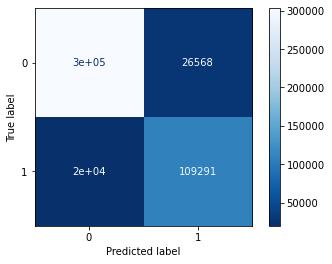

In [637]:
CLF_cm = plot_confusion_matrix(CLF_model,X_test,y_test,cmap='Blues_r')
CLF_cm

<AxesSubplot:>

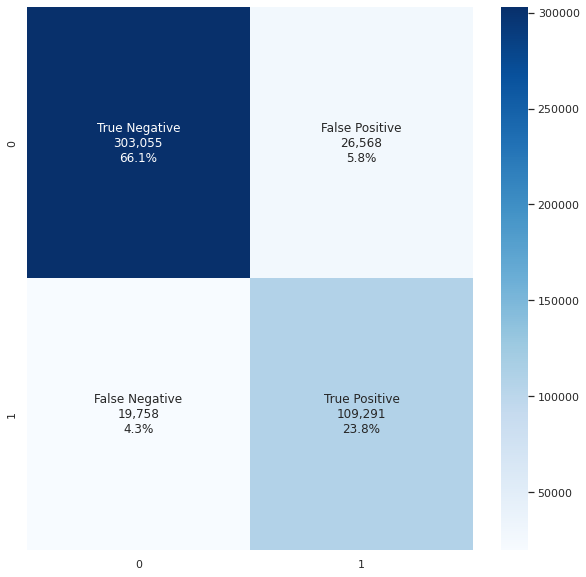

In [643]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=CLF_model.classes_)

sns.set(rc = {'figure.figsize':(10,10)})

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:,.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [335]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93    329623
           1       0.80      0.85      0.83    129049

    accuracy                           0.90    458672
   macro avg       0.87      0.88      0.88    458672
weighted avg       0.90      0.90      0.90    458672



In [336]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,0.639791,First_item_Unique_id_collection
70,0.071878,Price_USD_collection_cum_median
86,0.056046,Category_Art
68,0.037588,Price_Crypto_median_730d
71,0.011404,Price_USD_collection_cum_max
74,0.010039,p_resale
0,0.009899,nft_sales_count
10,0.009572,GoogleTrends_60d_rolling_avg
88,0.007569,Category_Games
73,0.006925,Price_Crypto_collection_cum_max


In [337]:
write_model_results_2(CLF_model, 'secondary2-49-xgboost-fill0-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary-logregr-fill0-nobal-noscale', 'secondary-logregr-fillcustom-nobal-noscale', 'secondary-logregr-fill0-nobal-minmaxscale', 'secondary-logregr-fillcustom-nobal-minmaxscale', 'secondary-lightgbm-fill0-nobal-noscale', 'secondary-lightgbm-fill0-nobal-minmaxscale', 'secondary-lightgbm-fillcustom-nobal-noscale', 'secondary-lightgbm-fillcustom-nobal-minmaxscale', 'secondary-xgboost-fill0-nobal-noscale', 'secondary-xgboost-fill0-nobal-minmaxscale', 'secondary-xgboost-fillcustom-nobal-noscale', 'secondary-xgboost-fillcustom-nobal-minmaxscale', 'secondary2-49-logregr-fill0-nobal-noscale', 'secondary2-49-logregr-fill0-nobal-minmaxscale', 'secondary2-49-logregr-fillcustom-nobal-noscale', 'secondary2-49-logregr-fillcustom-nobal-minmaxscale', 'secondary2-49-lightgbm-fill0-nobal-noscale', 'secondary2-49-lightgbm-fill0-nobal-minmaxscale', 'secondary2-49-lightgbm-fillcustom-nobal-noscale', 'secondary2-49-lightgbm-fillcustom-nobal-minmaxscale', 'secondary2-49-xgboost-fill0-nobal-nosc

#### XGBoost - FillNA=0, Unbalanced, Scaled

In [338]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [339]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 0)
print(len(X), len(y), len(indices))

2293360 2293360 2293360


In [340]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1834688 458672 1834688 458672 1834688 458672


In [341]:
%%time

# fit the model
# CLF_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model.fit(X_train,y_train)

# predict test values
y_pred = CLF_model.predict(X_test)

CPU times: user 53min 28s, sys: 787 ms, total: 53min 29s
Wall time: 6min 48s


In [342]:
train_acc_score, test_acc_score, bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("train_acc_score: ", train_acc_score)
print("test_acc_score: ", test_acc_score)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

train_acc_score:  0.9018094629713608
test_acc_score:  0.8956029581051383
balanced_acc_score:  0.8796992889758748
f1_score:  0.8196771934052857
precision_score:  0.7973142266863008
recall_score:  0.8433308278250897
roc_auc_score:  0.8796992889758748


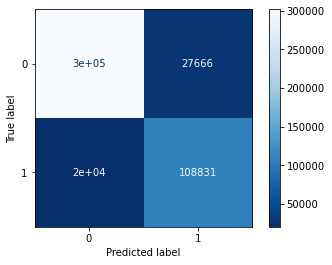

In [343]:
CLF_cm = plot_confusion_matrix(CLF_model,X_test,y_test,cmap='Blues_r')
CLF_cm

In [344]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93    329623
           1       0.80      0.84      0.82    129049

    accuracy                           0.90    458672
   macro avg       0.87      0.88      0.87    458672
weighted avg       0.90      0.90      0.90    458672



In [345]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,0.636220,First_item_Unique_id_collection
70,0.075281,Price_USD_collection_cum_median
86,0.064851,Category_Art
68,0.032657,Price_Crypto_median_730d
10,0.014116,GoogleTrends_60d_rolling_avg
74,0.009657,p_resale
71,0.009579,Price_USD_collection_cum_max
0,0.009117,nft_sales_count
64,0.007229,Price_Crypto_median_180d
73,0.006638,Price_Crypto_collection_cum_max


In [346]:
write_model_results_2(CLF_model, 'secondary2-49-xgboost-fill0-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-logregr-fill0-nobal-noscale', 'secondary-logregr-fillcustom-nobal-noscale', 'secondary-logregr-fill0-nobal-minmaxscale', 'secondary-logregr-fillcustom-nobal-minmaxscale', 'secondary-lightgbm-fill0-nobal-noscale', 'secondary-lightgbm-fill0-nobal-minmaxscale', 'secondary-lightgbm-fillcustom-nobal-noscale', 'secondary-lightgbm-fillcustom-nobal-minmaxscale', 'secondary-xgboost-fill0-nobal-noscale', 'secondary-xgboost-fill0-nobal-minmaxscale', 'secondary-xgboost-fillcustom-nobal-noscale', 'secondary-xgboost-fillcustom-nobal-minmaxscale', 'secondary2-49-logregr-fill0-nobal-noscale', 'secondary2-49-logregr-fill0-nobal-minmaxscale', 'secondary2-49-logregr-fillcustom-nobal-noscale', 'secondary2-49-logregr-fillcustom-nobal-minmaxscale', 'secondary2-49-lightgbm-fill0-nobal-noscale', 'secondary2-49-lightgbm-fill0-nobal-minmaxscale', 'secondary2-49-lightgbm-fillcustom-nobal-noscale', 'secondary2-49-lightgbm-fillcustom-nobal-minmaxscale', 'secondary2-49-xgboost-fill0-nobal-nosc

#### XGBoost - FillNA=Custom, Unbalanced, Unscaled

In [10]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'None'

In [11]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 1)
print(len(X), len(y), len(indices))

2289248 2289248 2289248


In [12]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1831398 457850 1831398 457850 1831398 457850


In [13]:
%%time

# fit the model
# CLF_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model.fit(X_train,y_train)

# predict test values
y_pred = CLF_model.predict(X_test)

CPU times: user 42min 26s, sys: 890 ms, total: 42min 27s
Wall time: 5min 21s


In [18]:
train_acc_score, test_acc_score, bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("train_acc_score: ", train_acc_score)
print("test_acc_score: ", test_acc_score)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

train_acc_score:  0.9015566250481872
test_acc_score:  0.8989297804957955
balanced_acc_score:  0.8833576243701193
f1_score:  0.825228967991691
precision_score:  0.8038940110815962
recall_score:  0.8477272374567407
roc_auc_score:  0.8833576243701193


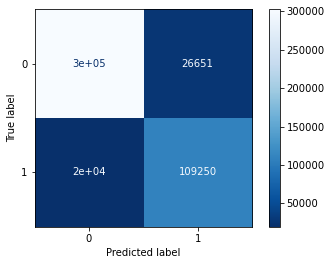

In [14]:
CLF_cm = plot_confusion_matrix(CLF_model,X_test,y_test,cmap='Blues_r')
CLF_cm

<AxesSubplot:>

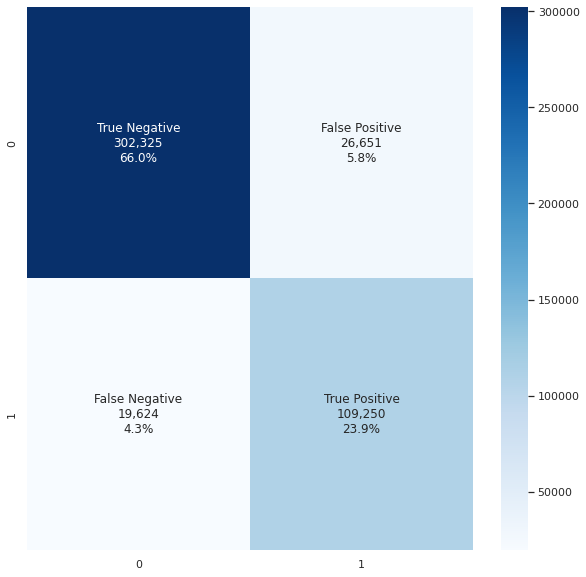

In [15]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=CLF_model.classes_)

sns.set(rc = {'figure.figsize':(10,10)})

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:,.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

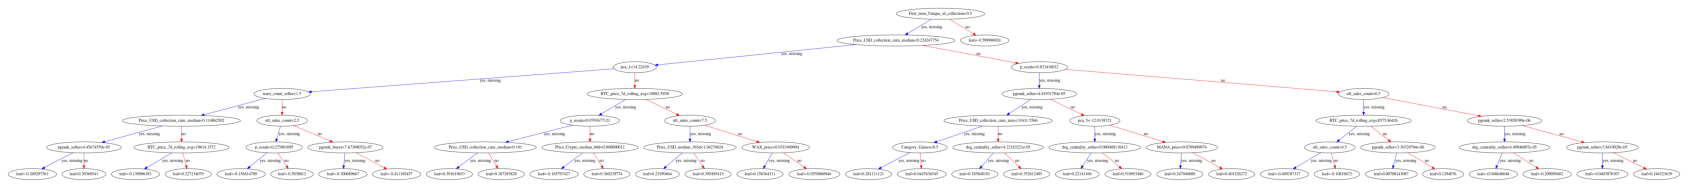

In [16]:
from xgboost import plot_tree

# plt.figure(figsize=(30, 30)) # Resize figure
# plot_tree(CLF_model)
# plt.show()

_, ax = plt.subplots(figsize=(30,50)) # Resize figure
plot_tree(CLF_model, filled=True, ax=ax)
plt.show()

In [17]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93    328976
           1       0.80      0.85      0.83    128874

    accuracy                           0.90    457850
   macro avg       0.87      0.88      0.88    457850
weighted avg       0.90      0.90      0.90    457850



In [18]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,0.686759,First_item_Unique_id_collection
70,0.088860,Price_USD_collection_cum_median
75,0.019871,pca_1
88,0.016396,Category_Games
68,0.014806,Price_Crypto_median_730d
64,0.014611,Price_Crypto_median_180d
71,0.010455,Price_USD_collection_cum_max
74,0.008339,p_resale
0,0.008005,nft_sales_count
48,0.007172,Price_USD_median_180d


In [21]:
CLF_model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

In [19]:
X_test.head(5)

,nft_sales_count,First_item_Unique_id_collection,GoogleTrends,BTC_price,ETH_price,MANA_price,WAX_price,GoogleTrends_7d_rolling_avg,GoogleTrends_14d_rolling_avg,GoogleTrends_30d_rolling_avg,...,deg_centrality_seller,pgrank_seller,trans_count_buyer,deg_centrality_buyer,pgrank_buyer,Category_Art,Category_Collectible,Category_Games,Category_Metaverse,Category_Other
955184,2,0,0,8783.1,188.36,0.0299,0.0267,0.000000,0.000000,0.000000,...,0.002845,8.899418e-07,22,0.000970,5.216978e-05,1,0,0,0,0
882982,2,0,0,11163.1,283.43,0.0593,0.0813,0.000000,0.000000,0.000000,...,0.003843,6.456454e-06,2,0.000008,7.669013e-07,1,0,0,0,0
953423,2,1,0,9036.8,188.99,0.0307,0.0296,0.000000,0.000000,0.000000,...,0.002845,8.899418e-07,219,0.001550,1.036322e-06,1,0,0,0,0
3051417,2,0,22,48963.6,2316.48,1.0943,0.1657,15.142857,15.857143,17.866667,...,0.001186,4.999383e-05,3,0.000572,8.361986e-06,0,1,0,0,0
2515057,3,0,3,52079.2,1847.95,0.2988,0.0748,2.142857,1.571429,1.266667,...,0.000008,8.763396e-07,1,0.000105,5.399616e-06,0,1,0,0,0


In [20]:
y_test.head(5)

955184     0
882982     0
953423     0
3051417    1
2515057    1
Name: Price_increase, dtype: int64

In [25]:
# for col in df_collection_nft_second_2_50.columns:
#     print(col, "---", df_collection_nft_second_2_50[col].loc[3051417])

In [26]:
# y.value_counts()

In [29]:
write_model_results_2(CLF_model, 'secondary2-49-xgboost-fillcustom-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary2-49-xgboost-fillcustom-nobal-noscale'])

In [31]:
model_results_dict['secondary2-49-xgboost-fillcustom-nobal-noscale']

{'model_scope': 'NFT sales 2-49',
 'model_type': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 'balance_method': 'None',
 'scale_method': 'None',
 'train_acc_score': 0.9015566250481872,
 'test_acc_score': 0.8989297804957955,
 'balance_acc_score': 0.8833576243701193,
 'f1_score': 0.825228967991691,
 'precision_score': 0.8038940110815

#### XGBoost - FillNA=Custom, Unbalanced, Scaled

In [356]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [357]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 1)
print(len(X), len(y), len(indices))

2289248 2289248 2289248


In [358]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1831398 457850 1831398 457850 1831398 457850


In [359]:
%%time

# fit the model
# CLF_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
CLF_model.fit(X_train,y_train)

# predict test values
y_pred = CLF_model.predict(X_test)

CPU times: user 42min 2s, sys: 806 ms, total: 42min 2s
Wall time: 5min 20s


In [360]:
train_acc_score, test_acc_score, bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("train_acc_score: ", train_acc_score)
print("test_acc_score: ", test_acc_score)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

train_acc_score:  0.9015467964909867
test_acc_score:  0.8974489461614066
balanced_acc_score:  0.8827637338626811
f1_score:  0.8233674287025576
precision_score:  0.7990930930492373
recall_score:  0.8491627481105576
roc_auc_score:  0.8827637338626813


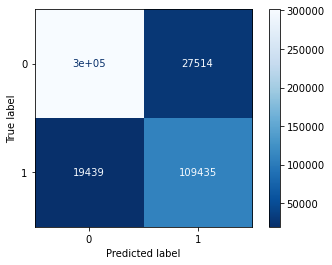

In [361]:
CLF_cm = plot_confusion_matrix(CLF_model,X_test,y_test,cmap='Blues_r')
CLF_cm

In [362]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93    328976
           1       0.80      0.85      0.82    128874

    accuracy                           0.90    457850
   macro avg       0.87      0.88      0.88    457850
weighted avg       0.90      0.90      0.90    457850



In [363]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,0.687536,First_item_Unique_id_collection
70,0.088274,Price_USD_collection_cum_median
75,0.020013,pca_1
88,0.016415,Category_Games
64,0.014628,Price_Crypto_median_180d
68,0.014226,Price_Crypto_median_730d
71,0.010466,Price_USD_collection_cum_max
74,0.008348,p_resale
0,0.008014,nft_sales_count
48,0.007180,Price_USD_median_180d


In [364]:
write_model_results_2(CLF_model, 'secondary2-49-xgboost-fillcustom-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-logregr-fill0-nobal-noscale', 'secondary-logregr-fillcustom-nobal-noscale', 'secondary-logregr-fill0-nobal-minmaxscale', 'secondary-logregr-fillcustom-nobal-minmaxscale', 'secondary-lightgbm-fill0-nobal-noscale', 'secondary-lightgbm-fill0-nobal-minmaxscale', 'secondary-lightgbm-fillcustom-nobal-noscale', 'secondary-lightgbm-fillcustom-nobal-minmaxscale', 'secondary-xgboost-fill0-nobal-noscale', 'secondary-xgboost-fill0-nobal-minmaxscale', 'secondary-xgboost-fillcustom-nobal-noscale', 'secondary-xgboost-fillcustom-nobal-minmaxscale', 'secondary2-49-logregr-fill0-nobal-noscale', 'secondary2-49-logregr-fill0-nobal-minmaxscale', 'secondary2-49-logregr-fillcustom-nobal-noscale', 'secondary2-49-logregr-fillcustom-nobal-minmaxscale', 'secondary2-49-lightgbm-fill0-nobal-noscale', 'secondary2-49-lightgbm-fill0-nobal-minmaxscale', 'secondary2-49-lightgbm-fillcustom-nobal-noscale', 'secondary2-49-lightgbm-fillcustom-nobal-minmaxscale', 'secondary2-49-xgboost-fill0-nobal-nosc

### Analyze results

In [26]:
# # not needed as TabNet GPU results have been included in https://storage.googleapis.com/nft_capstone_datafiles/df_model_results.pkl
# import pickle
# import io
# import torch

# class CPU_Unpickler(pickle.Unpickler):
#     def find_class(self, module, name):
#         if module == 'torch.storage' and name == '_load_from_bytes':
#             return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
#         else: return super().find_class(module, name)

# file_path = 'https://storage.googleapis.com/nft_capstone_datafiles/df_model_results_tabnet.pkl'

# with open(file_path , 'rb') as f:
#     contents = CPU_Unpickler(f).load()

In [24]:
df_model_results_file = pd.read_pickle('https://storage.googleapis.com/nft_capstone_datafiles/df_model_results.pkl')

In [25]:
print(len(df_model_results_file))

40


In [605]:
print(len(contents))
print(contents.columns)
contents.head()

8
Index(['unique_model_name', 'model_scope', 'model_type', 'balance_method',
       'scale_method', 'balance_acc_score', 'f1_score', 'precision_score',
       'recall_score', 'roc_auc_score', 'classification_report', 'features',
       'coef_values', 'date_recorded'],
      dtype='object')


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
4,secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07


In [607]:
print(len(df_model_results_file))
print(df_model_results_file.columns)
# print(df_model_results_file.columns == contents.columns)
df_model_results_file.head()

32
Index(['unique_model_name', 'model_scope', 'model_type', 'balance_method',
       'scale_method', 'train_acc_score', 'test_acc_score',
       'balance_acc_score', 'f1_score', 'precision_score', 'recall_score',
       'roc_auc_score', 'confusion_matrix', 'classification_report',
       'features', 'coef_values', 'date_recorded'],
      dtype='object')


,unique_model_name,model_scope,model_type,balance_method,scale_method,train_acc_score,test_acc_score,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,classification_report,features,coef_values,date_recorded
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-0.00011092048813094341, 0.0, -5.432995915618...",2022-04-05-02:40:03
1,secondary-logregr-fillcustom-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740838,0.740211,0.742014,0.741559,0.705676,0.781287,0.742014,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.307570248403485e-05, 0.0, -4.7352531896134...",2022-04-05-02:53:33
2,secondary-logregr-fill0-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.76255,0.763438,0.765601,0.765521,0.724886,0.810983,0.765601,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.120567329091572, 0.0, -0.3070797094569054,...",2022-04-05-03:15:37
3,secondary-logregr-fillcustom-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.763146,0.763667,0.765898,0.766806,0.724378,0.814512,0.765898,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-5.746898921650653, 0.0, -0.5322465729583994,...",2022-04-05-03:20:46
4,secondary-lightgbm-fill0-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,None,0.814194,0.813561,0.814446,0.809707,0.787663,0.83302,0.814446,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[190, 0, 3, 36, 45, 41, 14, 12, 7, 18, 11, 2, ...",2022-04-05-03:49:33


In [608]:
print(len(contents.columns))
print(len(df_model_results_file.columns))

14
17


In [609]:
for col in df_model_results_file.columns:
    if col not in contents.columns:
        print(col)
    else: pass

train_acc_score
test_acc_score
confusion_matrix


In [610]:
contents['train_acc_score'] = np.NaN
contents['test_acc_score'] = np.NaN
contents['confusion_matrix'] = np.NaN

In [611]:
print(type(contents))
print(type(df_model_results_file))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [620]:
df_model_results_from_files = pd.concat([df_model_results_file, contents], axis=0)
print(len(df_model_results_from_files))
# print(df_model_results_from_files.head())
# print(df_model_results_from_files.tail())

40


In [621]:
df_model_results_from_files

,unique_model_name,model_scope,model_type,balance_method,scale_method,train_acc_score,test_acc_score,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,classification_report,features,coef_values,date_recorded
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-0.00011092048813094341, 0.0, -5.432995915618...",2022-04-05-02:40:03
1,secondary-logregr-fillcustom-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740838,0.740211,0.742014,0.741559,0.705676,0.781287,0.742014,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.307570248403485e-05, 0.0, -4.7352531896134...",2022-04-05-02:53:33
2,secondary-logregr-fill0-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.76255,0.763438,0.765601,0.765521,0.724886,0.810983,0.765601,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.120567329091572, 0.0, -0.3070797094569054,...",2022-04-05-03:15:37
3,secondary-logregr-fillcustom-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.763146,0.763667,0.765898,0.766806,0.724378,0.814512,0.765898,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-5.746898921650653, 0.0, -0.5322465729583994,...",2022-04-05-03:20:46
4,secondary-lightgbm-fill0-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,None,0.814194,0.813561,0.814446,0.809707,0.787663,0.83302,0.814446,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[190, 0, 3, 36, 45, 41, 14, 12, 7, 18, 11, 2, ...",2022-04-05-03:49:33
5,secondary-lightgbm-fill0-nobal-minmaxscale,NFT secondary sales,LGBMClassifier(),None,MinMaxScaler,0.813999,0.810656,0.812135,0.809186,0.777857,0.843146,0.812135,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[173, 0, 3, 41, 47, 45, 19, 21, 11, 15, 15, 1,...",2022-04-05-04:00:19
6,secondary-lightgbm-fillcustom-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,None,0.814179,0.813456,0.81429,0.809804,0.788347,0.832461,0.81429,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[147, 0, 1, 48, 40, 39, 27, 9, 8, 11, 19, 0, 2...",2022-04-05-03:55:59
7,secondary-lightgbm-fillcustom-nobal-minmaxscale,NFT secondary sales,LGBMClassifier(),None,MinMaxScaler,0.814718,0.809926,0.811691,0.810156,0.773747,0.85016,0.811691,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[158, 0, 1, 40, 40, 34, 25, 14, 6, 13, 20, 0, ...",2022-04-05-03:58:40
8,secondary-xgboost-fill0-nobal-noscale,NFT secondary sales,"XGBClassifier(base_score=0.5, booster='gbtree'...",None,None,0.82877,0.823824,0.824433,0.819023,0.801614,0.837205,0.824433,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.04118315, 0.0, 0.002840959, 0.004702698, 0....",2022-04-05-04:13:26
9,secondary-xgboost-fill0-nobal-minmaxscale,NFT secondary sales,"XGBClassifier(base_score=0.5, booster='gbtree'...",None,MinMaxScaler,0.828458,0.819588,0.820864,0.817328,0.789123,0.847624,0.820864,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.04137135, 0.0, 0.0028612136, 0.0044366256, ...",2022-04-05-04:22:13


In [622]:
df_model_results_from_files.to_pickle('df_model_results.pkl')

In [623]:
df_model_results_from_files2 = df_model_results_from_files.explode(['features', 'coef_values'])
print(len(df_model_results_from_files2))
df_model_results_from_files2.head()

3640


,unique_model_name,model_scope,model_type,balance_method,scale_method,train_acc_score,test_acc_score,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,classification_report,features,coef_values,date_recorded
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,nft_sales_count,-0.000111,2022-04-05-02:40:03
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,First_item_Unique_id_collection,0.0,2022-04-05-02:40:03
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,GoogleTrends,-0.000001,2022-04-05-02:40:03
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,BTC_price,0.000061,2022-04-05-02:40:03
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,ETH_price,-0.000015,2022-04-05-02:40:03


In [624]:
df_model_results_from_files2.to_csv('df_model_results_exploded.csv')

In [496]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

32


,unique_model_name,model_scope,model_type,balance_method,scale_method,train_acc_score,test_acc_score,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,classification_report,features,coef_values,date_recorded
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740812,0.740861,0.74297,0.743129,0.703716,0.787219,0.74297,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-0.00011092048813094341, 0.0, -5.432995915618...",2022-04-05-02:40:03
1,secondary-logregr-fillcustom-nobal-noscale,NFT secondary sales,LogisticRegression(),None,None,0.740838,0.740211,0.742014,0.741559,0.705676,0.781287,0.742014,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.307570248403485e-05, 0.0, -4.7352531896134...",2022-04-05-02:53:33
2,secondary-logregr-fill0-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.76255,0.763438,0.765601,0.765521,0.724886,0.810983,0.765601,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-7.120567329091572, 0.0, -0.3070797094569054,...",2022-04-05-03:15:37
3,secondary-logregr-fillcustom-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),None,MinMaxScaler,0.763146,0.763667,0.765898,0.766806,0.724378,0.814512,0.765898,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[-5.746898921650653, 0.0, -0.5322465729583994,...",2022-04-05-03:20:46
4,secondary-lightgbm-fill0-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,None,0.814194,0.813561,0.814446,0.809707,0.787663,0.83302,0.814446,<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[190, 0, 3, 36, 45, 41, 14, 12, 7, 18, 11, 2, ...",2022-04-05-03:49:33


In [498]:
# df_model_results.to_pickle('df_model_results.pkl')

In [499]:
df_all_values['First_item_Collection_cleaned'].value_counts()

0    6066403
1       4624
Name: First_item_Collection_cleaned, dtype: int64

In [500]:
df_all_values['First_item_Unique_id_collection'].value_counts()

1    4678242
0    1392785
Name: First_item_Unique_id_collection, dtype: int64

In [504]:
ranges = [0, 1, 49, np.inf]  # np.inf for infinity
labels = ['1', '2-49', '50+']
df_all_values['model_category'] = pd.cut(df_all_values['nft_sales_count'], 
                                  bins=ranges, 
                                  labels=labels)
df_all_values['model_category'].value_counts()

1       3710713
2-49    2293360
50+       66954
Name: model_category, dtype: int64

In [575]:
df_all_values['model_category2'] = np.where(df_all_values['model_category'] == '1', '1 sale only', np.where(df_all_values['Price_increase'] == 0, 
                                                                                                            '2+ sales, no price increase', '2+ sales, price increase'))
df_all_values['model_category2'].value_counts()

1 sale only                    3710713
2+ sales, no price increase    1697605
2+ sales, price increase        662709
Name: model_category2, dtype: int64

In [505]:
df_all_values['Category'].value_counts()

Games          2643014
Collectible    1605657
Art            1472515
Other           272772
Metaverse        68372
Utility           8697
Name: Category, dtype: int64

In [576]:
df_group1 = df_all_values.groupby(df_all_values['Category'])['Category'].count()
df_group2 = df_all_values.groupby(['First_item_Collection_cleaned'])['First_item_Collection_cleaned'].count()
df_group3 = df_all_values.groupby(['First_item_Unique_id_collection'])['First_item_Unique_id_collection'].count()
df_group4 = df_all_values.groupby(['model_category'])['model_category'].count()
df_group5 = df_all_values.groupby(['model_category2'])['model_category2'].count()
print(type(df_group1), type(df_group2), type(df_group3), type(df_group4), type(df_group4))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [577]:
series_list = [df_group1, df_group2, df_group3, df_group4, df_group5]
sname_list = ['By Category', 'By Collection', 'By NFT', 'By Model Category', 'By Price Increase']

df_chart = pd.concat(series_list, axis=0, keys=sname_list).reset_index()  # columns=['Category1', 'Category2', 'Value']
df_chart2 = df_chart.rename(columns={'level_0':'Category1', 'level_1':'Category2', 0:'Value'})
df_chart2

,Category1,Category2,Value
0,By Category,Art,1472515
1,By Category,Collectible,1605657
2,By Category,Games,2643014
3,By Category,Metaverse,68372
4,By Category,Other,272772
5,By Category,Utility,8697
6,By Collection,0,6066403
7,By Collection,1,4624
8,By NFT,0,1392785
9,By NFT,1,4678242


In [578]:
df_chart2['Category2'].loc[6] = 'Secondary sales within Collection'
df_chart2['Category2'].loc[7] = 'Primary sales within Collection'
df_chart2['Category2'].loc[8] = 'Secondary sales of NFTs'
df_chart2['Category2'].loc[9] = 'Primary sales of NFTs'
df_chart2['Category2'].loc[10] = 'NFTs with 1 sale'
df_chart2['Category2'].loc[11] = 'NFTs with 2-49 sales'
df_chart2['Category2'].loc[12] = 'NFTs with 50+ sales'
df_chart2

,Category1,Category2,Value
0,By Category,Art,1472515
1,By Category,Collectible,1605657
2,By Category,Games,2643014
3,By Category,Metaverse,68372
4,By Category,Other,272772
5,By Category,Utility,8697
6,By Collection,Secondary sales within Collection,6066403
7,By Collection,Primary sales within Collection,4624
8,By NFT,Secondary sales of NFTs,1392785
9,By NFT,Primary sales of NFTs,4678242


In [625]:
df_chart2.to_csv('df_chart_data.csv')

In [630]:
df_all_values.groupby(['model_category'])['Unique_id_collection'].count()

model_category
1       3710713
2-49    2293360
50+       66954
Name: Unique_id_collection, dtype: int64

In [632]:
df_all_values.groupby(['model_category'])['Price_increase'].value_counts()

model_category  Price_increase
1               0                 3710713
2-49            0                 1648312
                1                  645048
50+             0                   49293
                1                   17661
Name: Price_increase, dtype: int64

In [627]:
df_all_values.groupby(['model_category'])['Unique_id_collection'].nunique()

model_category
1       3710713
2-49     967153
50+         376
Name: Unique_id_collection, dtype: int64

In [629]:
df_all_values.groupby(['model_category'])['ID_token'].nunique()

model_category
1       3474633
2-49     934611
50+         229
Name: ID_token, dtype: int64

In [590]:
import altair as alt
from altair import datum

source = df_chart2

selection = alt.selection_single()

base = alt.Chart(source).mark_bar().encode(
    x=alt.X('Category1', stack="normalize"),
    y=alt.Y('Value', axis=alt.Axis(title="NFT Transactions")),
    color=alt.condition(selection, 'Category2', alt.value('light grey'), scale=alt.Scale(scheme = 'category20')),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Category2',
      sort='ascending'), 
    tooltip = [alt.Tooltip('Category1:N'),
               alt.Tooltip('Category2:N'),
               alt.Tooltip('Value:N')
              ]
).properties(
    width=100,
    height=300
).add_selection(selection)

# text = base.mark_text(
#     # align='left',
#     # baseline='middle',
#     # dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='Value:Q'
# )

chart = alt.hconcat()
for Category1 in ['By Category', 'By Collection', 'By NFT', 'By Model Category', 'By Price Increase']:
    chart |= base.transform_filter(datum.Category1 == Category1)
chart

# display(base.resolve_scale(y='shared'))

alt.HConcatChart(...)

In [591]:
source = df_chart2

base = alt.Chart(source).mark_bar().encode(
    x=alt.X('Category1', stack="normalize"),
    y=alt.Y('Value', axis=alt.Axis(title="NFT Transactions")),
    color='Category2',
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Category2',
      sort='ascending')
).properties(
    width=100,
    height=300
).facet(
    column='Category1:N'
)

text = base.mark_text(
    # align='left',
    # baseline='middle',
    # dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Value:Q'
)

base + text

AttributeError: 'FacetChart' object has no attribute 'mark_text'

In [548]:
df_model_results.columns

Index(['unique_model_name', 'model_scope', 'model_type', 'balance_method',
       'scale_method', 'train_acc_score', 'test_acc_score',
       'balance_acc_score', 'f1_score', 'precision_score', 'recall_score',
       'roc_auc_score', 'confusion_matrix', 'classification_report',
       'features', 'coef_values', 'date_recorded'],
      dtype='object')

In [549]:
df_model_results_display = df_model_results[['unique_model_name', 'model_scope', 'model_type', 'scale_method', 'test_acc_score','f1_score', 'roc_auc_score']]
df_model_results_display

,unique_model_name,model_scope,model_type,scale_method,test_acc_score,f1_score,roc_auc_score
0,secondary-logregr-fill0-nobal-noscale,NFT secondary sales,LogisticRegression(),None,0.740861,0.743129,0.74297
1,secondary-logregr-fillcustom-nobal-noscale,NFT secondary sales,LogisticRegression(),None,0.740211,0.741559,0.742014
2,secondary-logregr-fill0-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),MinMaxScaler,0.763438,0.765521,0.765601
3,secondary-logregr-fillcustom-nobal-minmaxscale,NFT secondary sales,LogisticRegression(),MinMaxScaler,0.763667,0.766806,0.765898
4,secondary-lightgbm-fill0-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,0.813561,0.809707,0.814446
5,secondary-lightgbm-fill0-nobal-minmaxscale,NFT secondary sales,LGBMClassifier(),MinMaxScaler,0.810656,0.809186,0.812135
6,secondary-lightgbm-fillcustom-nobal-noscale,NFT secondary sales,LGBMClassifier(),None,0.813456,0.809804,0.81429
7,secondary-lightgbm-fillcustom-nobal-minmaxscale,NFT secondary sales,LGBMClassifier(),MinMaxScaler,0.809926,0.810156,0.811691
8,secondary-xgboost-fill0-nobal-noscale,NFT secondary sales,"XGBClassifier(base_score=0.5, booster='gbtree'...",None,0.823824,0.819023,0.824433
9,secondary-xgboost-fill0-nobal-minmaxscale,NFT secondary sales,"XGBClassifier(base_score=0.5, booster='gbtree'...",MinMaxScaler,0.819588,0.817328,0.820864


In [ ]:
alt.Chart(source).mark_bar().encode(
    x='wheat:Q',
    y="year:O"
).properties(height=700)

In [565]:
source = df_model_results_display[['unique_model_name', 'model_scope', 'scale_method', 'test_acc_score']]

base = alt.Chart(source).mark_bar().encode(
    x=alt.X('test_acc_score:Q', title="Accuracy", scale=alt.Scale(zero=False)),
    y=alt.Y('unique_model_name:N', title="Model", sort='-x'),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'test_acc_score:Q',
      sort='ascending')
).properties(
    width=500,
    height=600
)
base

# chart = alt.hconcat()
# for Category1 in ['By Category', 'By Collection', 'By NFT', 'By Model Category']:
#     chart |= base.transform_filter(datum.Category1 == Category1)
# chart

alt.Chart(...)